In [1]:
import pydicom
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [4]:
import pydicom
import numpy as np
import logging
from PIL import Image
import tensorflow as tf

def load_dicom_image(path, img_size=256, use_rgb=False):
    try:
        dicom = pydicom.dcmread(path)
        image = dicom.pixel_array

        # Adjusting normalization based on the actual range of the pixel data
        max_pixel_value = np.max(image)
        if max_pixel_value > 0:  # Prevent division by zero
            image = image / max_pixel_value  # Normalize the image

        if use_rgb:
            # Convert to RGB if needed (some models may require 3 channels)
            image = np.stack([image] * 3, axis=-1)

        image = Image.fromarray((image * 255).astype(np.uint8))  # Scale to 0-255 to use PIL
        image = image.resize((img_size, img_size))
        image = np.array(image) / 255.0  # Normalize the image back to 0-1

        # Assert to ensure all values are between 0 and 1
        assert np.all((image >= 0) & (image <= 1)), "Image values should be in the range [0, 1]"

        return tf.convert_to_tensor(image, dtype=tf.float32)
    except Exception as e:
        logging.error(f"Failed to process image {path}: {e}")
        return None


In [5]:
def process_patient_images(patient_folder, img_size=256):
    images = []
    try:
        for root, dirs, files in os.walk(patient_folder):
            for filename in files:
                if filename.endswith('.dcm'):
                    path = os.path.join(root, filename)
                    image = load_dicom_image(path, img_size=img_size)
                    if image is not None:
                        images.append(image)
    except Exception as e:
        logging.warning(f"Error processing folder {patient_folder}: {e}")
    return images

In [6]:
def process_data(folders, img_size, batch_size):
    all_images = []
    all_labels = []
    for folder_path, label in folders:
        images = process_patient_images(folder_path, img_size=img_size)
        all_images.extend(images)
        all_labels.extend([label] * len(images))
    
    dataset_images = tf.stack(all_images)
    dataset_labels = tf.convert_to_tensor(all_labels, dtype=tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((dataset_images, dataset_labels)).shuffle(buffer_size=1024).batch(batch_size)
    class_counts = {1: all_labels.count(1), 0: all_labels.count(0)}
    return dataset, class_counts

In [7]:
def create_datasets(root_dir, img_size=256, batch_size=32, val_split=0.15, test_split=0.15):
    patient_folders = []
    for condition in os.listdir(root_dir):
        condition_path = os.path.join(root_dir, condition)
        if os.path.isdir(condition_path):
            label = 1 if condition.lower() == 'cancer' else 0
            for patient_folder_name in os.listdir(condition_path):
                patient_folder_path = os.path.join(condition_path, patient_folder_name)
                if os.path.isdir(patient_folder_path):
                    patient_folders.append((patient_folder_path, label))
                    logging.info(f"Added folder {patient_folder_path} with label {label}")

    initial_split = 1 - (val_split + test_split)
    train_folders, temp_folders = train_test_split(patient_folders, test_size=(val_split + test_split), random_state=42)
    val_folders, test_folders = train_test_split(temp_folders, test_size=test_split/(val_split + test_split), random_state=42)

    train_dataset, train_counts = process_data(train_folders, img_size, batch_size)
    val_dataset, val_counts = process_data(val_folders, img_size, batch_size)
    test_dataset, test_counts = process_data(test_folders, img_size, batch_size)
    
    print("Training Class Distribution:", train_counts)
    print("Validation Class Distribution:", val_counts)
    print("Testing Class Distribution:", test_counts)

    return train_dataset, val_dataset, test_dataset

In [8]:
train_dataset, val_dataset, test_dataset = create_datasets(root_dir='/Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/new_train_data', img_size=256, batch_size=32)

2024-04-20 17:14:14,015 - INFO - Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/new_train_data/non_cancer/Prostate-MRI-US-Biopsy-1135 with label 0
2024-04-20 17:14:14,015 - INFO - Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/new_train_data/non_cancer/Prostate-MRI-US-Biopsy-0645 with label 0
2024-04-20 17:14:14,015 - INFO - Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/new_train_data/non_cancer/Prostate-MRI-US-Biopsy-0221 with label 0
2024-04-20 17:14:14,016 - INFO - Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/new_train_data/non_cancer/Prostate-MRI-US-Biopsy-0013 with label 0
2024-04-20 17:14:14,016 - INFO - Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/new_train_data/non_cancer/Prostate-MRI-US-Biopsy-0448 with label 0
2024-04-20 17:14:14,017 - INFO - Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/new_train_data/non_cancer/Prostate-MRI-US-Biopsy-0014

Training Class Distribution: {1: 6333, 0: 3899}
Validation Class Distribution: {1: 1275, 0: 979}
Testing Class Distribution: {1: 1236, 0: 805}


In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
from tensorflow.keras.metrics import Recall, AUC

def build_model_with_resnet(input_shape=(256, 256, 1), dropout_rate=0.4, l2_reg=0.005):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    base_model.trainable = False

    model = Sequential([
        Lambda(lambda x: tf.image.grayscale_to_rgb(x), input_shape=input_shape),
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),  # Add Batch Normalization after global average pooling
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', Recall(), AUC()])
    
    return model

# Create the model with the specified metrics
model = build_model_with_resnet()


/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/core/lambda_layer.py:66: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,            
    verbose=1,             
    restore_best_weights=True)  


In [25]:
model = build_model_with_resnet()

# Assuming you have your datasets ready as train_dataset and val_dataset
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,             # Number of epochs to train for
    batch_size=32,         # Size of the batches of data (optional, depending on your data loader)
    verbose=1              # Show training log
)


Epoch 1/40
320/320 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - accuracy: 0.5770 - auc_4: 0.5590 - loss: 0.6954 - recall_4: 0.7600 - val_accuracy: 0.5657 - val_auc_4: 0.5677 - val_loss: 0.6955 - val_recall_4: 1.0000
Epoch 2/40
320/320 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.6078 - auc_4: 0.6033 - loss: 0.6660 - recall_4: 0.8473 - val_accuracy: 0.5710 - val_auc_4: 0.5947 - val_loss: 0.7018 - val_recall_4: 0.9694
Epoch 3/40
320/320 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.6117 - auc_4: 0.6136 - loss: 0.6620 - recall_4: 0.8507 - val_accuracy: 0.5852 - val_auc_4: 0.5724 - val_loss: 0.7011 - val_recall_4: 0.9380
Epoch 4/40
320/320 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - accuracy: 0.6189 - auc_4: 0.6305 - loss: 0.6544 - recall_4: 0.8531 - val_accuracy: 0.5785 - val_auc_4: 0.5530 - val_loss: 0.7171 - val_recall_4: 0.9451
Epoch 5/40
320/320 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - accuracy: 0.6172 - auc_4: 0.6285 - loss: 0.6549 - recall_4: 0.8509 - val_accuracy: 0.5878 - val_auc_4: 0.58

In [27]:
# Assuming test_dataset is your TensorFlow dataset or a generator that yields batches of test data
test_loss, test_auc, test_recall, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test AUC: {test_auc}")
print(f"Test Recall: {test_recall}")
print(f"Test Accuracy: {test_accuracy}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6081 - auc_4: 0.5067 - loss: 0.6959 - recall_4: 0.9407


In [38]:
# Retrieve the last values of training and validation metrics from history for comparison
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_auc = history.history['auc_4'][-1]
final_val_auc = history.history['val_auc_4'][-1]

# Extract training and validation metrics across all epochs
epochs = range(1, len(history.history['accuracy']) + 1)  # epoch count
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc_4']
val_auc = history.history['val_auc_4']
train_recall = history.history['recall_4']
val_recall = history.history['val_recall_4']

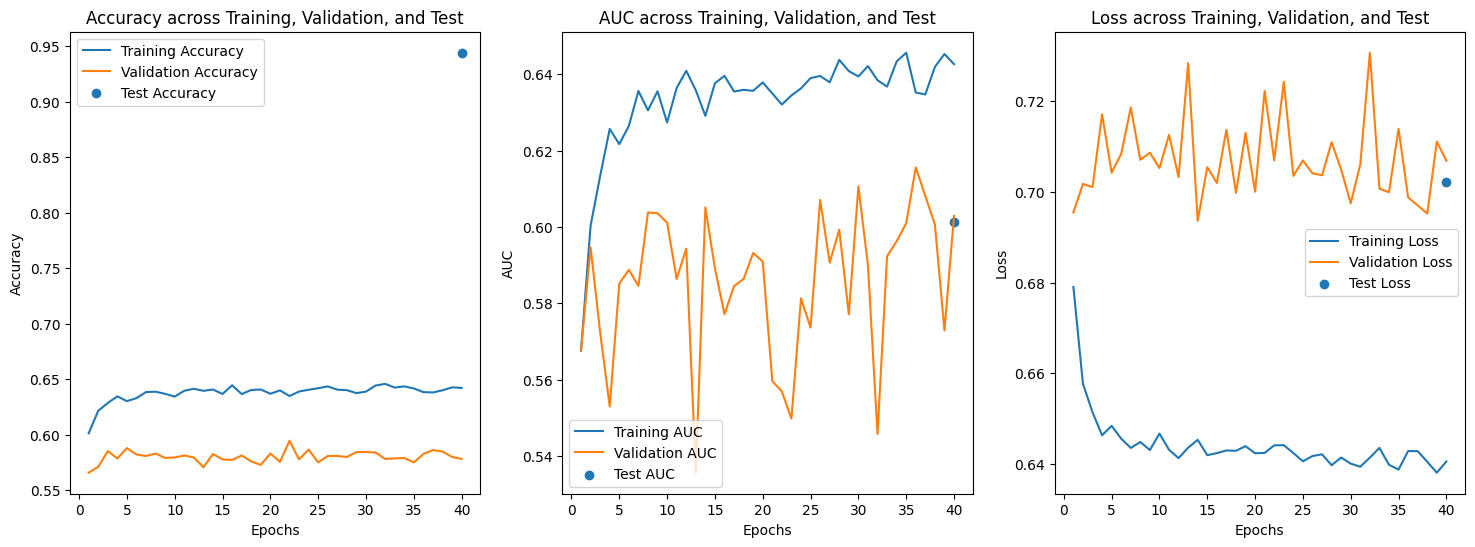

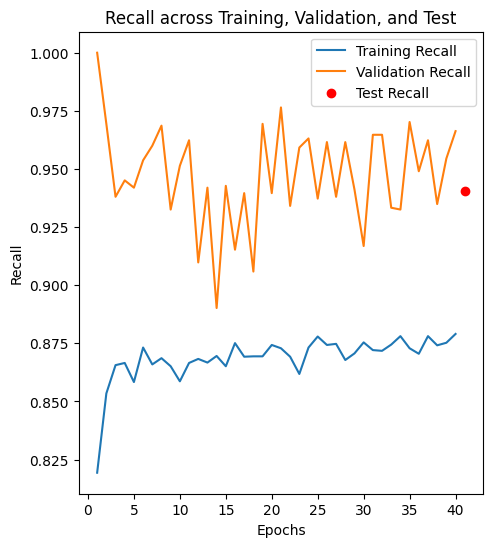

In [43]:
import matplotlib.pyplot as plt

# Create a figure for plotting
plt.figure(figsize=(18, 6))

# Plot Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.scatter(len(train_acc), test_accuracy, label='Test Accuracy')  # Test as point
plt.title('Accuracy across Training, Validation, and Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot AUC
plt.subplot(1, 3, 2)
plt.plot(epochs, train_auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.scatter(len(train_auc), test_auc, label='Test AUC')  # Test as point
plt.title('AUC across Training, Validation, and Test')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Plot Loss
plt.subplot(1, 3, 3)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.scatter(len(train_loss), test_loss, label='Test Loss')  # Test as point
plt.title('Loss across Training, Validation, and Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [28]:
import keras_tuner as kt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def build_model(hp):
    input_shape = (256, 256, 3)
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    l2_reg = hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='log')
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    loss_function = hp.Choice('loss_function', ['binary_crossentropy', 'hinge'])

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss=loss_function,
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

    return model

In [29]:
def tuner_search(train_dataset, val_dataset):
    tuner = kt.RandomSearch(
        build_model,
        objective='val_auc',
        max_trials=10,
        executions_per_trial=1,
        directory='my_dir',
        project_name='intro_to_kt'
    )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    tuner.search(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[stop_early])

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    The hyperparameter search is complete. The optimal dropout rate is {best_hps.get('dropout_rate')},
    the optimal L2 regularization is {best_hps.get('l2_reg')},
    the optimal learning rate is {best_hps.get('learning_rate')},
    and the optimal loss function is {best_hps.get('loss_function')}.
    """)

    # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)
    
    return model, history


In [10]:
""" model = build_model_with_resnet()

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Or another appropriate loss function
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]) """

In [30]:
# Calling the tuner_search function with the training and validation datasets
model, history = tuner_search(train_dataset, val_dataset)

# After tuning and training, evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Reloading Tuner from my_dir/intro_to_kt/tuner0.json

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
0.4               |0.2               |dropout_rate
0.00029843        |0.0085163         |l2_reg
0.0041168         |0.0011324         |learning_rate
hinge             |binary_crossent...|loss_function

Epoch 1/50


Traceback (most recent call last):
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, mod

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/ops/operation_utils.py", line 184, in compute_conv_output_shape
    raise ValueError(
ValueError: Exception encountered when calling Functional.call().

[1mKernel shape must have the same length as input, but received kernel of shape (7, 7, 262, 64) and input of shape (None, 262, 262).[0m

Arguments received by Functional.call():
  • args=('<KerasTensor shape=(None, 256, 256), dtype=float32, sparse=None, name=keras_tensor_175>',)
  • kwargs={'mask': 'None'}


In [ ]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset) 

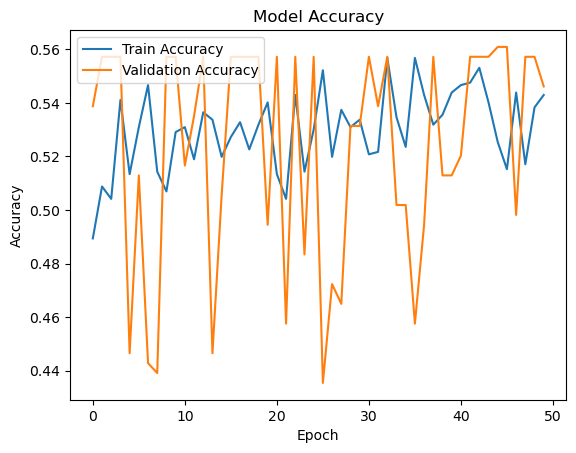

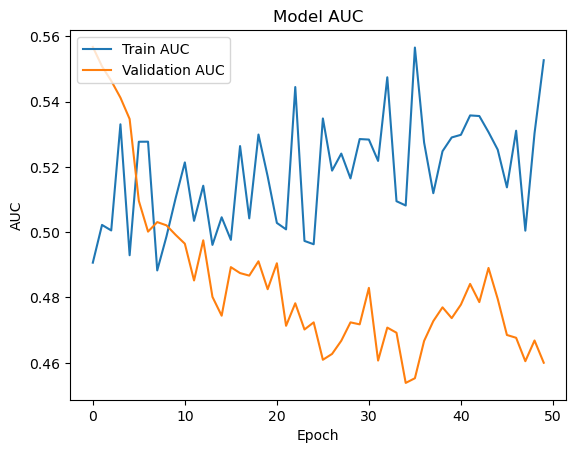

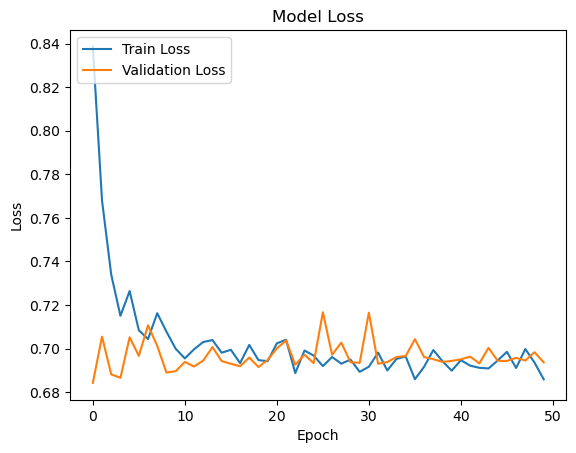

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation AUC values
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')  
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')  
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [3]:
# dicom_dir_path = '/Users/arjunmoorthy/Desktop/Research_Capstone/Image Data/CapstoneData'  # Directory where DICOM files are stored

tensor([1.], device='mps:0')
